In [14]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [15]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../../data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

## Do your thing crazy machine learning thing here :) ...

In [16]:
from logistic_regression import *
from helpers import *
from costs import *

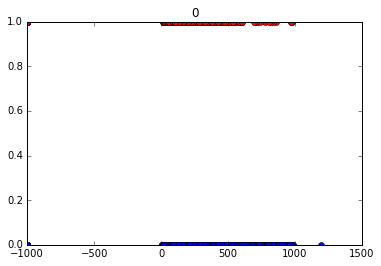

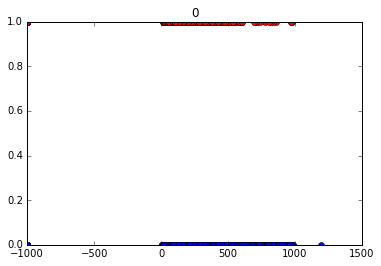

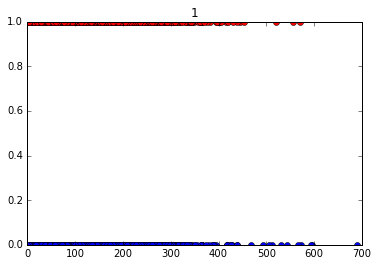

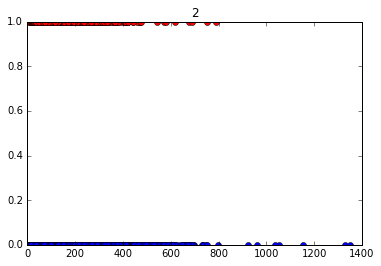

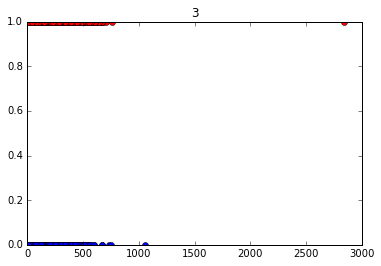

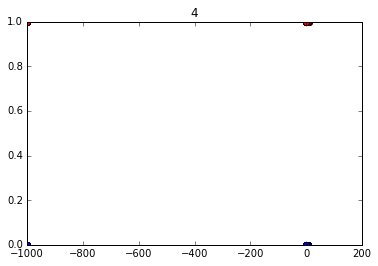

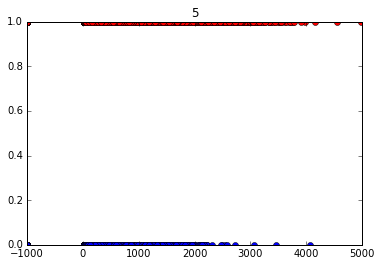

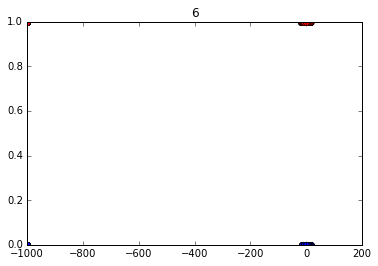

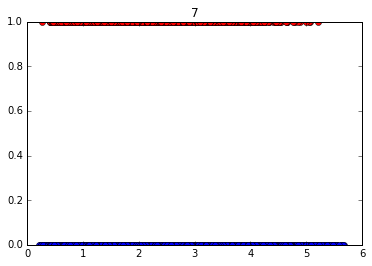

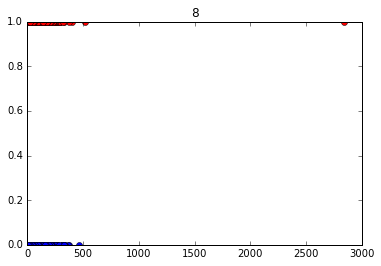

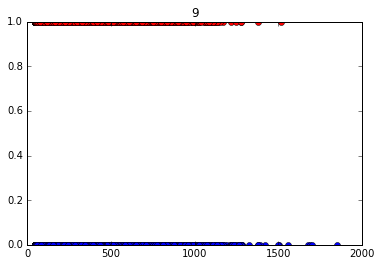

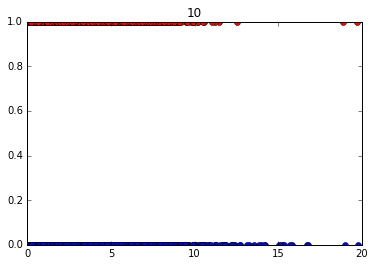

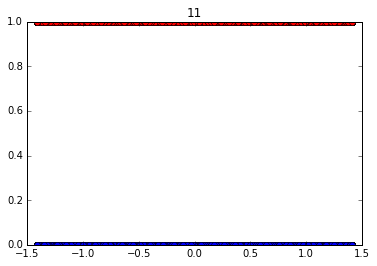

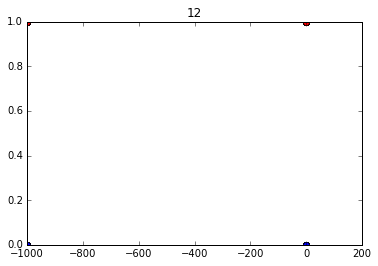

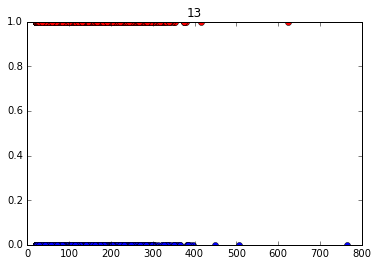

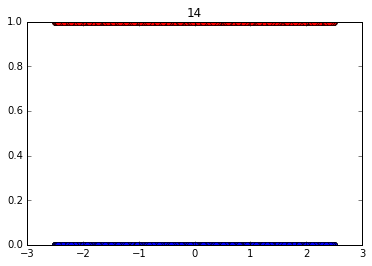

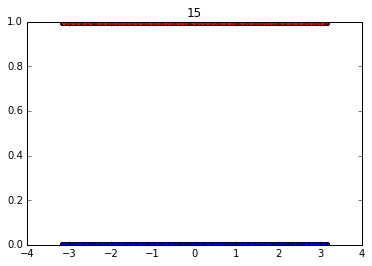

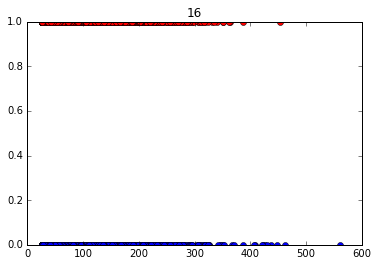

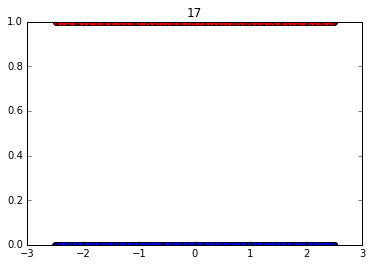

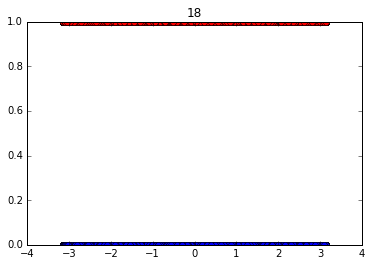

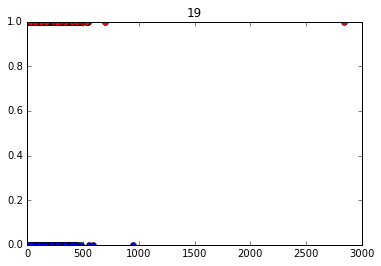

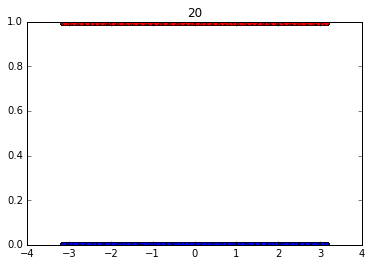

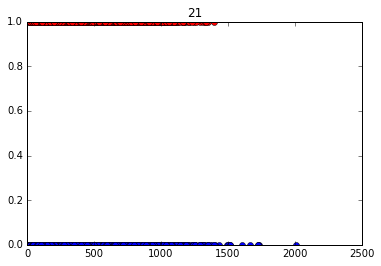

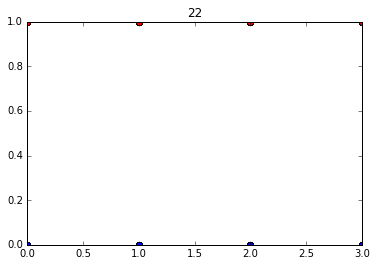

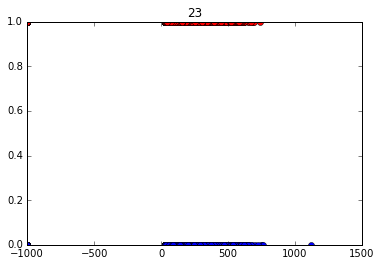

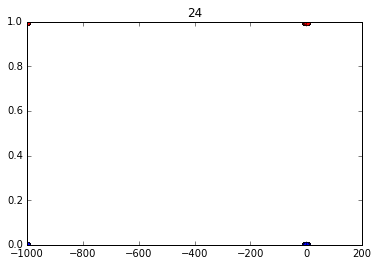

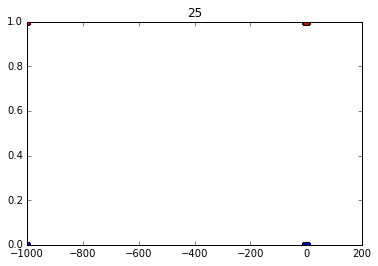

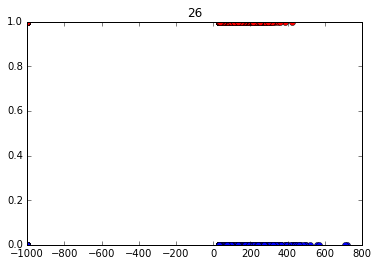

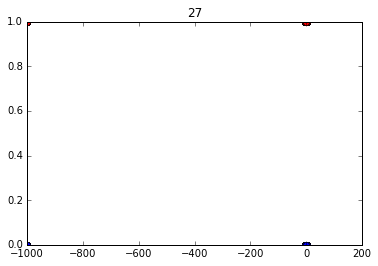

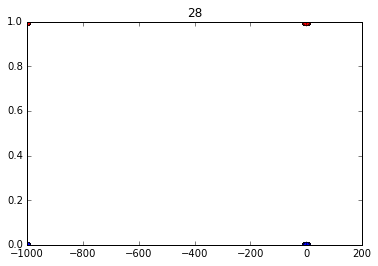

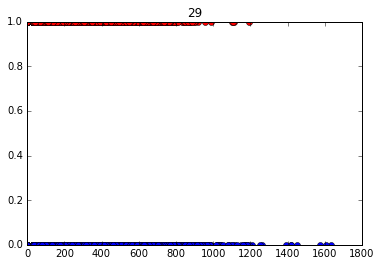

In [62]:

row = np.zeros(tX.shape[0])

for i in range(len(tX)):
    row[i] = tX[i][0]

y[np.where(y == -1)] = 0
    

for j in range(tX.shape[1]):
    for i in range(len(tX)):
        row[i] = tX[i][j]
    plt.title(j)
    plt.plot(row[np.where(y == 1)], y[np.where(y == 1)], 'ro')
    plt.plot(row[np.where(y == 0)], y[np.where(y == 0)], 'bo')
    plt.show()




In [40]:


# There are two parameters, lambda_ and gamma, where gamma is the step size 

max_iter = 20000
lambdas = np.arange(0.1, 0.4, 0.1)
gammas = [0.5]

# When lambda is 0, reg_logistic_regression is naive non-penalized logistic_regression.

tx, _, std_x = standardize(tX)

weights = reg_logistic_regression(y, tx, lambdas[0], gammas[0], max_iter)
# err = compute_loss(y, tX, w)
# struct[(gamma, lambda_)] = (w, err)
# #         break
print(weights)
# for (gamma, lambda_), (w, err) in struct.items():
#     print("Gamma: ", gamma, " Lamdba: ", lambda_, " w: ", w, "error: ", err)
        
        

        


[[ 14187.56452566]
 [-20848.53205722]
 [  -833.83185996]
 [ 11421.66201088]
 [  8403.17614897]
 [ 11376.56059522]
 [  8338.41723459]
 [   726.46556678]
 [  -906.92957136]
 [  9090.75159575]
 [-11592.01831993]
 [ 16121.73313427]
 [  8385.37835498]
 [ 13955.53882204]
 [   -55.95855309]
 [  -261.18146666]
 [ -1895.29682131]
 [    89.95095961]
 [   244.74297271]
 [  1332.78509222]
 [   443.47613404]
 [  8039.76595952]
 [  7922.82778687]
 [  9349.89669626]
 [  8926.61821419]
 [  8926.54570359]
 [  8347.90727758]
 [  8380.56857542]
 [  8380.02116578]
 [  7967.12019039]]
Performance:  0.638892
Iteration:  0
Current iteration=0, the loss=173286.79513998624
Current iteration=100, the loss=8044929437.424736
Current iteration=200, the loss=10364511317.089073
[[  3.10413540e+03]
 [ -7.97799171e+04]
 [ -1.12701100e+05]
 [  8.25174934e+04]
 [ -7.81261838e+03]
 [  3.40100627e+05]
 [ -1.39064469e+04]
 [  8.87329271e+04]
 [ -1.83529271e+03]
 [ -2.79047885e+04]
 [ -5.91904383e+04]
 [  2.74985043e+04]
 [

KeyboardInterrupt: 

In [34]:
weights =      [  3264.41428568,
  -103498.43040039,
   -27944.48648106,
   -36731.0555926 ,
   -82923.2716588 ,
     2761.63293809,
   -24230.40255878,
   409836.06933039,
    14829.8163511 ,
    38230.32931558,
  -284541.39042936,
   662654.74622621,
    80791.09716388,
    65926.74105577,
    -1032.49192099,
   -17500.88986746,
    24786.4442881 ,
    -7594.73927   ,
    14068.93010338,
    42981.56765674,
     6275.32816837,
    -6455.53314786,
  -164153.32220581,
    13395.30580001,
   -10880.4029573 ,
     1141.95701937,
     1170.96908066,
    12837.31514973,
    10274.84678099,
   -52489.01936993]
compare_pred = predict_labels(weights, tX) - y
print(compare_pred.shape)

nonzero = 0
for i in range(len(compare_pred)):
    if (compare_pred[i] != 0):
        nonzero += 1

print(1 - nonzero / compare_pred.size)

(250000,)
0.719484


## Generate predictions and save ouput in csv format for submission:

In [12]:
DATA_TEST_PATH = '../../data/test.csv' 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [13]:
OUTPUT_PATH = '../../data/output.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)